In [28]:
"""
This Jupyter notebook provides examples for loading data and running baselines from the Treated Room.
"""
%pip install -r requirements.txt
import sys
sys.path.insert(0, 'dataset/')
import dataset
import room_setup
import room_config
import dataset
import os
import numpy as np
import s3fs
import zipfile

Note: you may need to restart the kernel to use updated packages.


In [52]:
DATASET_BASE_PATH = "/home/onyxia/work/ia_data_hack_acoustic/data/LivingRoom_preprocessed_hack/" #<---Use the path in your directory

DATASET_PATH1 = os.path.join(DATASET_BASE_PATH, "Human1") 
DATASET_PATH2 = os.path.join(DATASET_BASE_PATH, "Human2") 

dr = dataset.Dataset(room_setup.RoomSetup(room_config.speaker_xyz,
                room_config.mic_xyzs_base,
                room_config.x_min,
                room_config.x_max,
                room_config.y_min,
                room_config.y_max,
                room_config.walls), (DATASET_PATH1, DATASET_PATH2))


print("Treated Room Dataset Loaded")

Treated Room Dataset Loaded


In [71]:
#Loading centroid (human xy positions)
centroid = np.load(os.path.join(DATASET_PATH1, "centroid.npy"))
centroid2 = np.load(os.path.join(DATASET_PATH2, "centroid.npy"))
#centroid = np.concatenate(centroid1, centroid2)
print("Shape of Centroid:")
print(centroid.shape)


#Loading Room Impulse Response (1000 human locations x 10 microphones x M time samples)
RIRs = np.load(os.path.join(DATASET_PATH1, "deconvoled_trim.npy"), mmap_mode='r')
RIRs2 = np.load(os.path.join(DATASET_PATH2, "deconvoled_trim.npy"), mmap_mode='r')

print("Shape of RIRs:")
print(RIRs.shape)

Shape of Centroid:
(1000, 2)
Shape of RIRs:
(1000, 4, 667200)


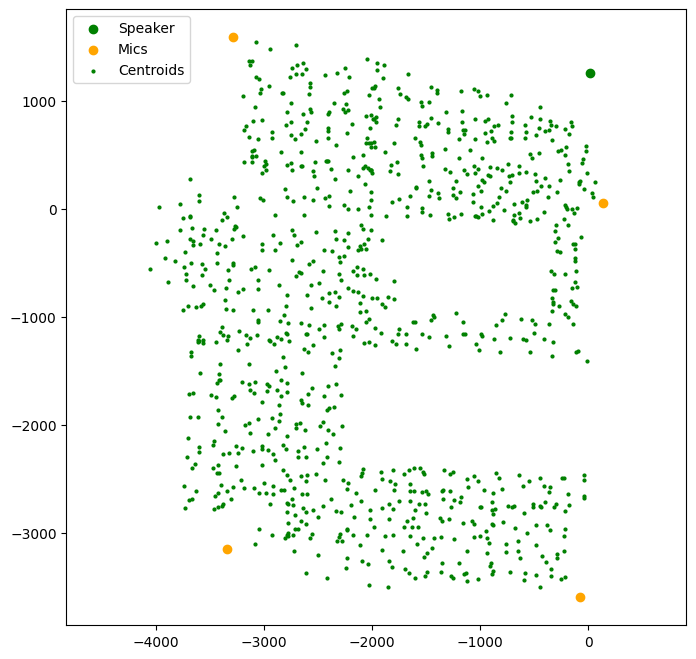

In [54]:
dr.room_setup.plot_room(centroid)

In [5]:
train_indices = np.load("indices/train_indices.npy")
train_xys = centroid[train_indices]

print("Shape of Training xys")
print(train_xys.shape)

Shape of Training xys
(800, 2)


In [6]:
rir_path = os.path.join(DATASET_PATH, "deconvoled_trim.npy")
centroid_path = os.path.join(DATASET_PATH, "centroid.npy")

In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

2024-04-25 10:18:54.932772: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 10:18:55.892332: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [72]:
# Calcul de la RMS pour chaque canal (microphone)
rms_data = np.sqrt(np.mean(np.square(RIRs), axis=2))
print(rms_data.shape)
print(RIRs.shape)
# Normaliser les données RMS
scaler = StandardScaler()
rms_data = rms_data.reshape(1000,-1)
rms_data_normalized = scaler.fit_transform(rms_data)
print(rms_data_normalized)

(1000, 4)
(1000, 4, 667200)
[[  0.807686     0.89319843   0.3703625    0.55446833]
 [  0.6148092    0.5601817    0.32530993   0.49623522]
 [  0.6670591    0.46835804   0.26275572   0.5050229 ]
 ...
 [  0.48971906   0.02091012  -0.3304132   -0.05839473]
 [  0.38563752  -0.5528933   -0.33424938  -0.18044513]
 [  0.38350895   0.30132347 -10.254325    -4.594716  ]]


In [62]:
X_train, X_test, y_train, y_test = train_test_split(rms_data_normalized,centroid1,test_size=0.2,random_state=42)

In [30]:
import os
import random
import sys
import numpy as np
import torch
import torchaudio.functional as F
from torchsummary import summary

sys.path.insert(0, 'VGGish/')
import config
import models

In [69]:
#déclaration de variables
normalized=False
multi_chan=True
complex_vggish=False
resnet1d=False
wavelet=False
pretrained=False
seed=1337
batch_size = 64
epochs = 100
num_channels = 4 #ou 1

In [33]:
rand = random.Random(seed)
    
np.random.seed(0)
deconv = RIRs
print("Deconv Loaded")
print("Centroid Loaded")

if num_channels == 1:
    mic_indices = [0]
elif num_channels == 4:
    mic_indices = [0,1,2,3]
else:
    print('error in mic_indices')


Deconv Loaded
Centroid Loaded


In [34]:
deconv = deconv[:, mic_indices, :]
print(deconv.shape)
print(centroid.shape)

(1000, 4, 667200)
(1000, 2)


In [68]:
rms_data_normalized

array([[  0.807686  ,   0.89319843,   0.3703625 ,   0.55446833],
       [  0.6148092 ,   0.5601817 ,   0.32530993,   0.49623522],
       [  0.6670591 ,   0.46835804,   0.26275572,   0.5050229 ],
       ...,
       [  0.48971906,   0.02091012,  -0.3304132 ,  -0.05839473],
       [  0.38563752,  -0.5528933 ,  -0.33424938,  -0.18044513],
       [  0.38350895,   0.30132347, -10.254325  ,  -4.594716  ]],
      dtype=float32)

In [35]:
train_indices = np.load("indices/train_indices.npy")
valid_indices = np.load("indices/valid_indices.npy")
test_indices = np.load("indices/test_indices.npy")

In [36]:
#Centroids
train_xy = centroid[train_indices]
valid_xy = centroid[valid_indices]
test_xy = centroid[test_indices]

train_mean = np.mean(train_xy, axis=0)
train_std = np.std(train_xy, axis=0)

print(train_std)
print(np.max(train_xy, axis=0))
print(np.min(train_xy, axis=0))
train_xy = (train_xy - train_mean) / (train_std + 1e-8)
valid_xy = (valid_xy - train_mean) / (train_std + 1e-8)
test_xy =  (test_xy - train_mean) / (train_std + 1e-8)

[1065.49002101 1413.40889991]
[  56.83489407 1542.25968982]
[-4002.15528594 -3499.88767611]


In [37]:
#Code insertion ends
epsilon = 1e-2
norm_val_min = np.min(np.concatenate((train_xy, valid_xy), axis=0))
norm_val_range = np.max(np.concatenate((train_xy, valid_xy), axis=0)) - norm_val_min

In [38]:
def postprocess_net_output(output):
    output[:, :2] = norm_val_range * ((torch.tanh(output[:, :2]) * (1 + epsilon)) + 1) / 2 + norm_val_min
    return output


train_std_cuda = torch.Tensor(train_std).cuda()
train_mean_cuda = torch.Tensor(train_mean).cuda()

In [39]:
def unnormalize(xy):
    return xy*(train_std_cuda + 1e-8) + train_mean_cuda

def resample(audio, ir=48000, tr=16000):

    resampled_waveform = F.resample(
    audio,
    ir,
    tr,
    lowpass_filter_width=64,
    rolloff=0.9475937167399596,
    resampling_method="kaiser_window",
    beta=14.769656459379492,
    )
    return resampled_waveform

In [40]:
train_waves = deconv[train_indices, :]
# 30950 seems to be the rough cutoff after which vggish treats the input as two examples.
valid_waves = deconv[valid_indices, :]
#Test Waves
test_waves = deconv[test_indices, :]

offset = 0
precutoff = 92850

In [41]:
train_waves = train_waves[..., (offset):(offset+precutoff)]
valid_waves = valid_waves[..., (offset):(offset+precutoff)]
test_waves = test_waves[..., (offset):(offset+precutoff)]

train_waves = torch.Tensor(train_waves).cuda()
train_xy = torch.Tensor(train_xy).cuda()

valid_waves = torch.Tensor(valid_waves).cuda()
valid_xy = torch.Tensor(valid_xy).cuda()

test_waves = torch.Tensor(test_waves).cuda()
test_xy = torch.Tensor(test_xy).cuda()

In [42]:
vggish_cutoff = 15475

train_waves = train_waves[..., :vggish_cutoff]
valid_waves = valid_waves[..., :vggish_cutoff]
test_waves = test_waves[..., :vggish_cutoff]

out_channels = 2

print("Done Resampling")

Done Resampling


In [43]:
net = models.CustomVGGish2(num_channels, out_channels)

In [44]:
summary(net)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,368
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       73,856
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       295,168
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       590,080
|    └─ReLU: 2-10                        --
|    └─MaxPool2d: 2-11                   --
|    └─Conv2d: 2-12                      1,180,160
|    └─ReLU: 2-13                        --
|    └─Conv2d: 2-14                      2,359,808
|    └─ReLU: 2-15                        --
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-2                        --
|    └─Linear: 2-17                      50,335,744
|    └─ReLU: 2-18                        --
|    └─Linear: 2-19             

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       2,368
|    └─ReLU: 2-2                         --
|    └─MaxPool2d: 2-3                    --
|    └─Conv2d: 2-4                       73,856
|    └─ReLU: 2-5                         --
|    └─MaxPool2d: 2-6                    --
|    └─Conv2d: 2-7                       295,168
|    └─ReLU: 2-8                         --
|    └─Conv2d: 2-9                       590,080
|    └─ReLU: 2-10                        --
|    └─MaxPool2d: 2-11                   --
|    └─Conv2d: 2-12                      1,180,160
|    └─ReLU: 2-13                        --
|    └─Conv2d: 2-14                      2,359,808
|    └─ReLU: 2-15                        --
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-2                        --
|    └─Linear: 2-17                      50,335,744
|    └─ReLU: 2-18                        --
|    └─Linear: 2-19             

In [45]:
total_params = sum(p.numel() for p in net.parameters())
trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print('Total parameters: %i'%total_params)
print('Trainable parameters: %i'%trainable_params)

Total parameters: 72242242
Trainable parameters: 72242242


In [46]:
xy_loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(params=net.parameters(), betas=(0.9, 0.999))
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999995)

print("Number of samples per epoch:", train_waves.shape[0])

Number of samples per epoch: 800


In [70]:
N_iter = int(train_waves.shape[0] / batch_size)
train_losses = []
train_xy_losses = []
valid_losses = []
valid_xy_losses = []
step_count = 0
for n in range(epochs):
    print('Reshuffling for Epoch %i'%n, flush=True)
    rand_idx = np.random.permutation(train_waves.shape[0])
    net.train()
    optimizer.zero_grad()
    for i in range(N_iter):
        curr_idx = rand_idx[i*batch_size:(i+1)*batch_size]
        net_out = net(train_waves[curr_idx, :])
        results = postprocess_net_output(net_out)
        xy_loss = xy_loss_fn(results[:, :2], train_xy[curr_idx, :2])
        loss = xy_loss
        optimizer.zero_grad()
        loss.backward()
        train_loss = loss.item()
        train_losses.append((step_count, train_loss))
        train_xy_losses.append((step_count, xy_loss.item()))
        step_count+=1
        optimizer.step()
        scheduler.step()

    net.eval()
    valid_loss_xy_arr = np.zeros(valid_waves.shape[0], dtype=np.float32)
    valid_loss_arr = np.zeros(valid_waves.shape[0], dtype=np.float32)
    for i in range(valid_waves.shape[0]):
        with torch.no_grad():
            results = torch.squeeze(postprocess_net_output(net(torch.unsqueeze(valid_waves[i, :], axis=0)).view(-1, 1)))
        xy_loss = xy_loss_fn(results[:2], valid_xy[i, :2])
        valid_loss_xy_arr[i] = xy_loss.item()
        loss = xy_loss
        valid_loss_arr[i] = loss.item()
    valid_xy_loss = np.mean(valid_loss_xy_arr)
    valid_loss = np.mean(valid_loss_arr)
    print('Validation XY Loss: %0.3f'%valid_xy_loss)
    print('Validation Loss: %0.3f'%valid_loss)
    valid_losses.append((step_count, valid_loss))
    valid_xy_losses.append((step_count, valid_xy_loss))

    error_path = '../err'

    if not os.path.exists(error_path):
        os.makedirs(error_path)

    np.save(os.path.join(error_path, 'train_losses.npy'), np.array(train_losses, dtype=np.float32))
    np.save(os.path.join(error_path, 'valid_losses.npy'), np.array(valid_losses, dtype=np.float32))

    #Iterate through test
    test_errors = np.zeros(test_waves.shape[0], dtype=np.float32)

    for i in range(test_waves.shape[0]):
        with torch.no_grad():
            results = torch.squeeze(postprocess_net_output(net(torch.unsqueeze(test_waves[i, :], axis=0)).view(-1, 1)))
        
        
        test_errors[i] = torch.norm(unnormalize(results[:2]) - unnormalize(test_xy[i, :2])).item()

    print("TEST ERROR")
    print(test_errors)
    
    print("MEAN TEST ERROR",flush=True)
    print(np.mean(test_errors))
    print("MED TEST ERROR")
    print(np.median(test_errors))
    print("STD TEST ERROR")
    print(np.std(test_errors))

    np.save(os.path.join(error_path, 'test_errors.npy'), np.array(test_errors, dtype=np.float32))        

    save_path = "dataset/predict.pt" 

    torch.save({
        'epoch': n,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'train_xy_losses': train_xy_losses,
        'valid_losses': valid_losses,
        'valid_xy_losses': valid_xy_losses,
        'train_mean': train_mean,
        'train_std': train_std,
        'norm_val_min':norm_val_min,
        'norm_val_range':norm_val_range,
        'lr': None,
        }, save_path)

Reshuffling for Epoch 0
Validation XY Loss: 0.920
Validation Loss: 0.920
TEST ERROR
[1981.6555  2363.93    1703.978   2008.0038  1926.0941  1887.358
 2206.3618  1434.971    989.92426 1918.9922  1977.3077  1002.1677
 1148.1449  1170.6216  1341.1195  1423.3926  2160.2542  1593.0215
 1460.0762  1852.4398  1913.8329  2007.3682  2968.0457  1815.4838
 1562.826   1865.7036  1885.1357  1923.5607  2527.3984  1914.172
  264.14923 2138.8274   612.3497  1408.8823  1575.8772  2079.1409
 1939.9905  1598.3232  1073.3982  2528.143   2141.586   1475.3322
  450.21805  718.69855 1952.8345  1036.1675  2155.685   2589.348
 1914.4075  2352.0786  1524.1886  2100.0322  2242.3667  1358.6768
 1607.4506  1560.4823  1627.729   1147.0026  2308.9167  1513.4894
 1788.1215  1756.0911  2278.877   1971.9789  1165.5355  1422.6681
 2442.291    963.21576 1703.9624  2521.326   1900.178    941.5966
  110.5707  1984.754    866.0402  2084.7305  1397.0267  1053.8752
 2455.1062   503.2594  1928.8208   795.02905  958.4911   974.